In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
import umap
import hdbscan

d:\Apps\anaconda3\envs\poop\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Wczytanie danych

In [4]:
real_data = pd.read_csv('original_data/GSE158508_normalized_counts.tsv', sep='\t')
real_data = real_data.T
synthetic_data = pd.read_csv('synthetic_data/generated_data.tsv', sep='\t')

In [5]:
# keep only the columns that are in both datasets
real_data = real_data[real_data.columns.intersection(synthetic_data.columns)]
# synthetic_data = real_data
# # add noise to synthetic data
# synthetic_data = synthetic_data + np.random.normal(0, 0.01, synthetic_data.shape)

In [6]:
real_data.describe()

,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000001036,ENSG00000001084,ENSG00000001461,ENSG00000001497,ENSG00000001631,ENSG00000002549,...,ENSG00000259162,ENSG00000263264,ENSG00000266401,ENSG00000266714,ENSG00000267121,ENSG00000267243,ENSG00000268555,ENSG00000269028,ENSG00000271043,ENSG00000273143
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,...,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,3.064805,1.895148,2.491433,5.024288,3.625457,1.947125,3.155479,2.637453,3.092953,4.343543,...,2.391782,1.904397,3.619364,4.074264,2.117094,3.453274,4.681122,4.173351,2.965915,1.856344
std,1.449007,1.169756,1.197725,1.877605,1.119283,1.256447,1.416964,1.448021,1.337983,1.429289,...,1.231598,1.248553,1.146714,1.806725,1.263918,1.226016,1.187721,1.419830,1.229484,1.193917
min,0.873160,0.873160,0.873160,0.873160,0.873160,0.873160,0.873160,0.873160,0.873160,0.873160,...,0.873160,0.873160,0.873160,0.873160,0.873160,0.873160,1.704808,0.873160,0.873160,0.873160
25%,2.241929,0.873160,0.873160,3.952013,3.101348,0.873160,2.180503,0.873160,2.239232,3.488690,...,0.873160,0.873160,3.314088,2.609450,0.873160,3.033262,3.962861,3.076781,2.192123,0.873160
50%,3.342033,1.652023,2.475884,5.051057,3.842482,1.652023,3.608865,2.616140,3.461463,4.189586,...,2.641590,0.873160,3.891818,4.300591,2.222980,3.733726,4.889429,4.065619,3.013937,1.544206
75%,4.109352,2.752148,3.431087,6.115508,4.194681,2.919484,4.266243,3.652197,4.012245,5.249452,...,3.385797,2.949903,4.238603,5.291463,3.033262,4.089997,5.547316,5.159893,3.676555,2.624802
max,6.206670,5.103477,5.141266,9.258977,6.015839,5.198191,5.112800,5.520058,5.789930,8.014585,...,4.956431,4.692518,5.533572,8.243906,4.939630,5.855044,6.377282,7.780260,6.162483,5.762052


### Porównanie rozkładów danych rzeczywistych i syntetycznych

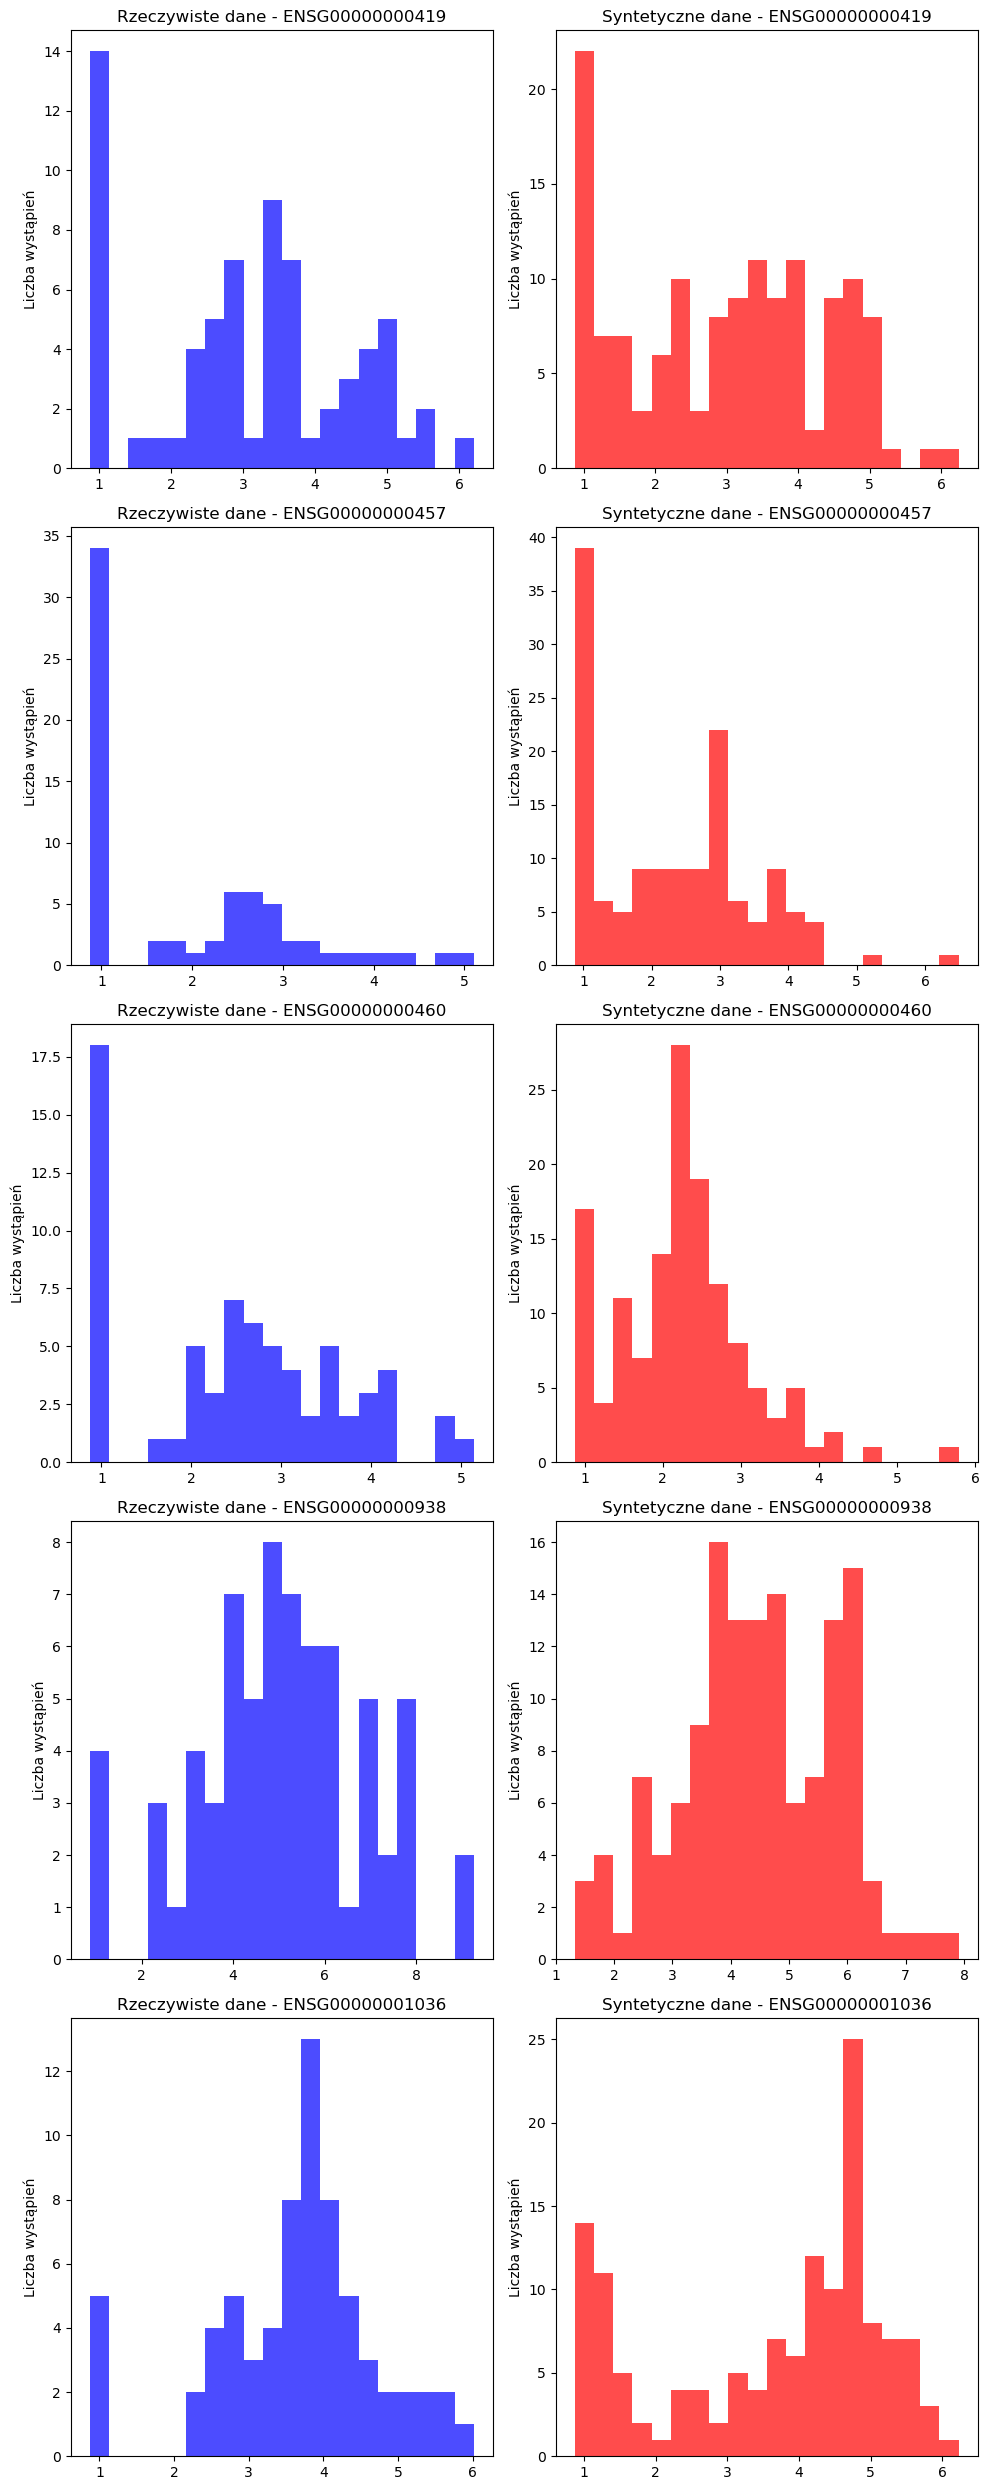

In [144]:
def compare_distributions(real_data, synthetic_data, n_columns=5):
    fig, axes = plt.subplots(nrows=n_columns, ncols=2, figsize=(10, 5*n_columns))
    for i, column in enumerate(real_data.columns):
        if i == n_columns:
            break
        # Histogram dla danych rzeczywistych
        axes[i, 0].hist(real_data[column], bins=20, color='blue', alpha=0.7)
        axes[i, 0].set_title(f'Rzeczywiste dane - {column}')
        axes[i, 0].set_ylabel('Liczba wystąpień')
        
        # Histogram dla danych syntetycznych
        axes[i, 1].hist(synthetic_data[column], bins=20, color='red', alpha=0.7)
        axes[i, 1].set_title(f'Syntetyczne dane - {column}')
        axes[i, 1].set_ylabel('Liczba wystąpień')
        
    plt.tight_layout()
    plt.show()

compare_distributions(real_data, synthetic_data)

### Wykorzystanie PCA do wizualizacji różnorodności danych

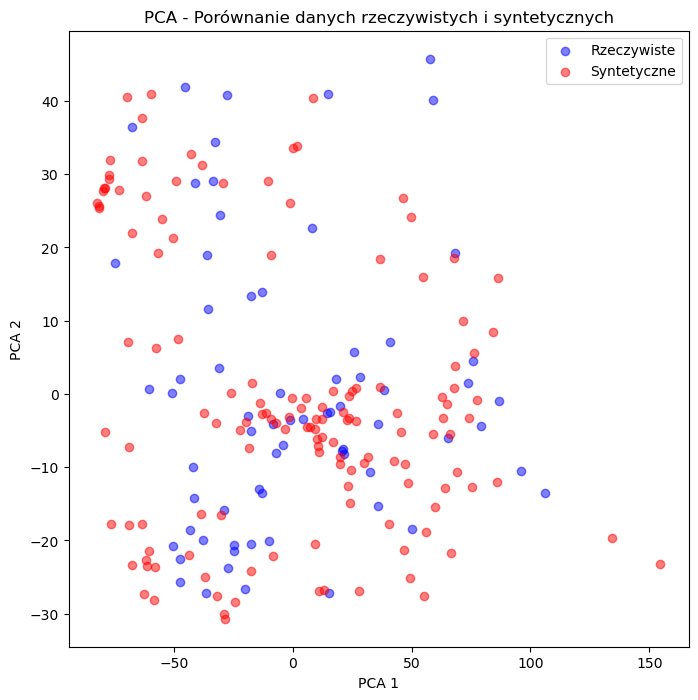

In [145]:
def pca_visualization(real_data, synthetic_data):
    # Standaryzacja danych
    scaler = StandardScaler()
    real_scaled = scaler.fit_transform(real_data)
    synthetic_scaled = scaler.transform(synthetic_data)
    
    # PCA do 2 komponentów
    pca = PCA(n_components=2, random_state=42)
    real_pca = pca.fit_transform(real_scaled)
    synthetic_pca = pca.transform(synthetic_scaled)
    
    # Wizualizacja
    plt.figure(figsize=(8, 8))
    plt.scatter(real_pca[:, 0], real_pca[:, 1], c='blue', alpha=0.5, label='Rzeczywiste')
    plt.scatter(synthetic_pca[:, 0], synthetic_pca[:, 1], c='red', alpha=0.5, label='Syntetyczne')
    plt.legend()
    plt.title('PCA - Porównanie danych rzeczywistych i syntetycznych')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.show()

pca_visualization(real_data, synthetic_data)

### Wykorzystanie TSNE do wizualizacji różnorodności danych

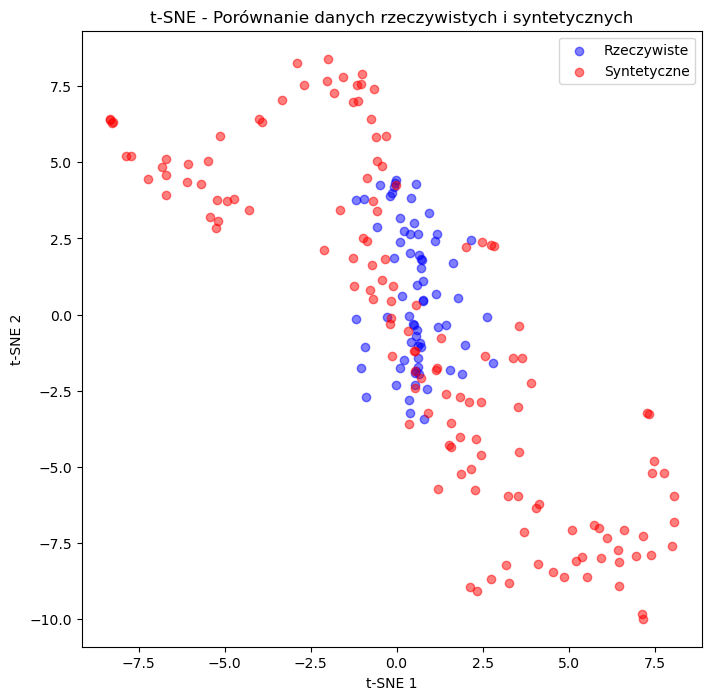

In [146]:
from sklearn.manifold import TSNE


def tsne_visualization(real_data, synthetic_data):
    # Standaryzacja danych
    scaler = StandardScaler()
    real_scaled = scaler.fit_transform(real_data)
    synthetic_scaled = scaler.transform(synthetic_data)
    
    # PCA do 2 komponentów
    pca = PCA(n_components=2)
    real_pca = pca.fit_transform(real_scaled)
    synthetic_pca = pca.transform(synthetic_scaled)
    
    # t-SNE do 2 komponentów
    tsne = TSNE(n_components=2, random_state=42)
    real_tsne = tsne.fit_transform(real_data)
    synthetic_tsne = tsne.fit_transform(synthetic_data)
    
    # Wizualizacja
    plt.figure(figsize=(8, 8))
    plt.scatter(real_tsne[:, 0], real_tsne[:, 1], c='blue', alpha=0.5, label='Rzeczywiste')
    plt.scatter(synthetic_tsne[:, 0], synthetic_tsne[:, 1], c='red', alpha=0.5, label='Syntetyczne')
    plt.legend()
    plt.title('t-SNE - Porównanie danych rzeczywistych i syntetycznych')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()

tsne_visualization(real_data, synthetic_data)

### Wykorzystanie UMAP do wizualizacji różnorodności danych

d:\Apps\anaconda3\envs\poop\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
d:\Apps\anaconda3\envs\poop\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


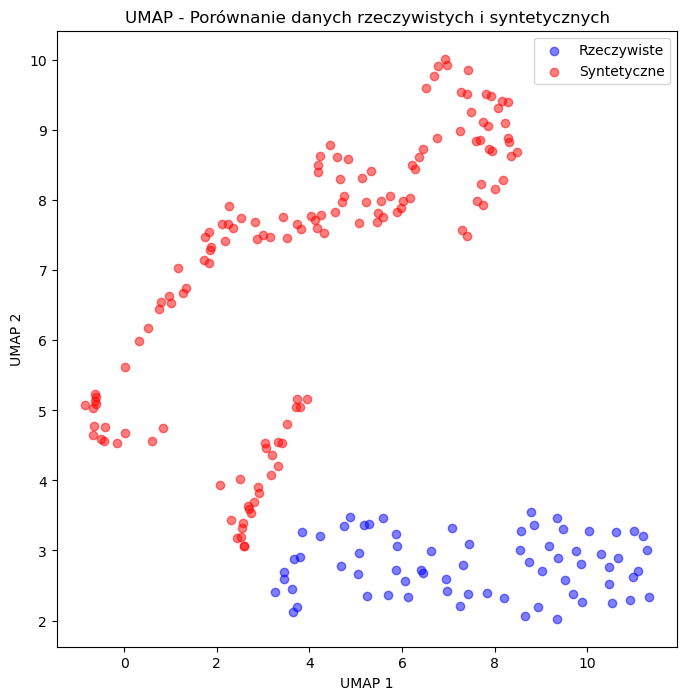

In [147]:
from umap import UMAP
def umap_visualization():
    # Standaryzacja danych
    scaler = StandardScaler()
    real_scaled = scaler.fit_transform(real_data)
    synthetic_scaled = scaler.transform(synthetic_data)
    
    # PCA do 2 komponentów
    pca = PCA(n_components=2)
    real_pca = pca.fit_transform(real_scaled)
    synthetic_pca = pca.transform(synthetic_scaled)
    
    # UMAP do 2 komponentów
    umap = UMAP(n_components=2, random_state=42)
    real_umap = umap.fit_transform(real_data)
    synthetic_umap = umap.fit_transform(synthetic_data)
    
    # Wizualizacja
    plt.figure(figsize=(8, 8))
    plt.scatter(real_umap[:, 0], real_umap[:, 1], c='blue', alpha=0.5, label='Rzeczywiste')
    plt.scatter(synthetic_umap[:, 0], synthetic_umap[:, 1], c='red', alpha=0.5, label='Syntetyczne')
    plt.legend()
    plt.title('UMAP - Porównanie danych rzeczywistych i syntetycznych')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.show()

umap_visualization()

### Wykorzystanie DBSCAN do wizualizacji różnorodności danych

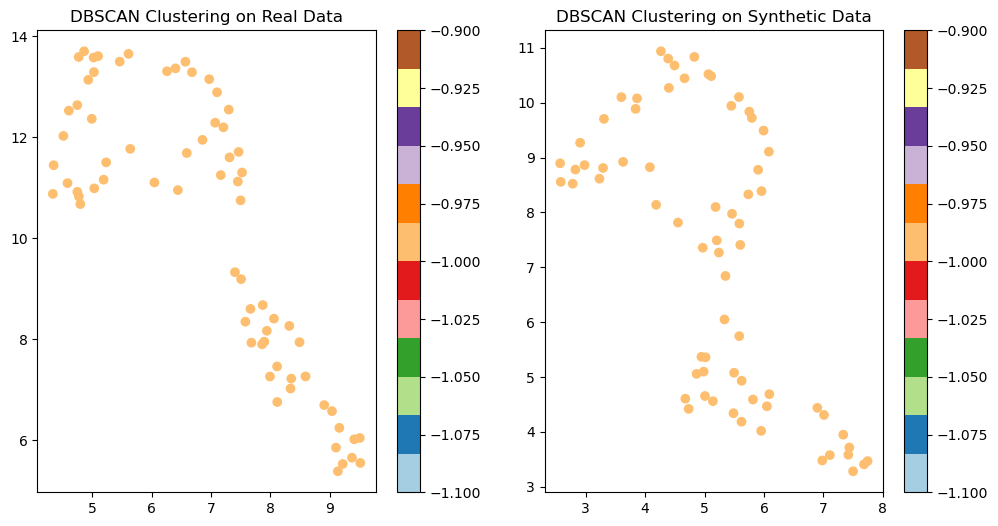

In [94]:
# Standaryzacja danych
scaler = StandardScaler()
real_scaled = scaler.fit_transform(real_data)
synthetic_scaled = scaler.transform(synthetic_data)
    
# PCA do 2 komponentów
pca = PCA(n_components=2)
real_pca = pca.fit_transform(real_scaled)
synthetic_pca = pca.transform(synthetic_scaled)
    
# UMAP do 2 komponentów
umap = UMAP(n_components=2)
real_umap = umap.fit_transform(real_pca)
synthetic_umap = umap.fit_transform(synthetic_pca)

# Przykładowe parametry, które mogą wymagać dostosowania
eps_value = 0.5  # Przykładowa wartość dla eps, zależna od skali danych
min_samples_value = 10  # Przykładowa minimalna liczba próbek w sąsiedztwie

# Klastrowanie DBSCAN dla danych rzeczywistych
dbscan_real = DBSCAN(eps=eps_value, min_samples=min_samples_value).fit(real_umap)
real_labels = dbscan_real.labels_

# Klastrowanie DBSCAN dla danych syntetycznych
dbscan_synthetic = DBSCAN(eps=eps_value, min_samples=min_samples_value).fit(synthetic_umap)
synthetic_labels = dbscan_synthetic.labels_

# Wizualizacja wyników
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(real_umap[:, 0], real_umap[:, 1], c=real_labels, cmap='Paired', label='Real Data')
plt.title('DBSCAN Clustering on Real Data')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(synthetic_umap[:, 0], synthetic_umap[:, 1], c=synthetic_labels, cmap='Paired', label='Synthetic Data')
plt.title('DBSCAN Clustering on Synthetic Data')
plt.colorbar()

plt.show()


### Analiza klastrów i identyfikacja anomalii

d:\Apps\anaconda3\envs\poop\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Apps\anaconda3\envs\poop\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Apps\anaconda3\envs\poop\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Apps\anaconda3\envs\poop\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, wh

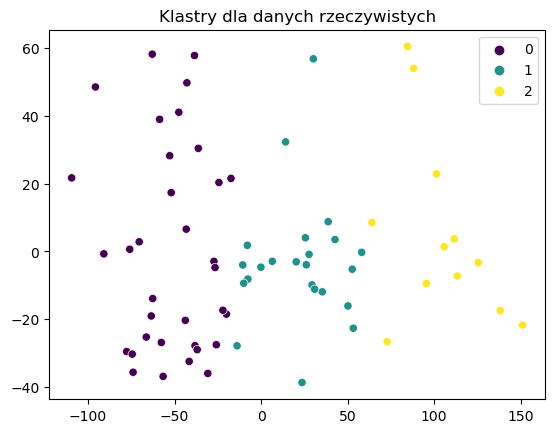

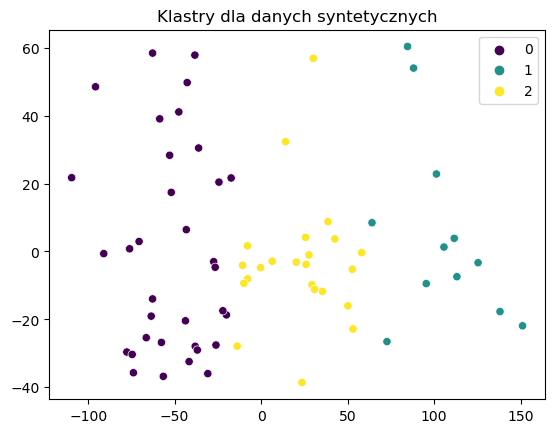

In [95]:
# Załóżmy, że zredukowaliśmy już dane do dwóch głównych komponentów dla łatwiejszej wizualizacji
pca = PCA(n_components=2)
real_data_2d = pca.fit_transform(real_data)
synthetic_data_2d = pca.transform(synthetic_data)

# Dopasuj K-means do danych rzeczywistych
kmeans_real = KMeans(n_clusters=3)  # Załóżmy, że chcemy 3 klastry
real_clusters = kmeans_real.fit_predict(real_data_2d)

# Dopasuj K-means do danych syntetycznych
kmeans_synthetic = KMeans(n_clusters=3)  # Ta sama liczba klastrów dla porównania
synthetic_clusters = kmeans_synthetic.fit_predict(synthetic_data_2d)

# Wizualizacja klastrów dla danych rzeczywistych
sns.scatterplot(x=real_data_2d[:, 0], y=real_data_2d[:, 1], hue=real_clusters, palette='viridis')
plt.title('Klastry dla danych rzeczywistych')
plt.show()

# Wizualizacja klastrów dla danych syntetycznych
sns.scatterplot(x=synthetic_data_2d[:, 0], y=synthetic_data_2d[:, 1], hue=synthetic_clusters, palette='viridis')
plt.title('Klastry dla danych syntetycznych')
plt.show()

### Wykorzystanie HDBSCAN do wizualizacji różnorodności danych

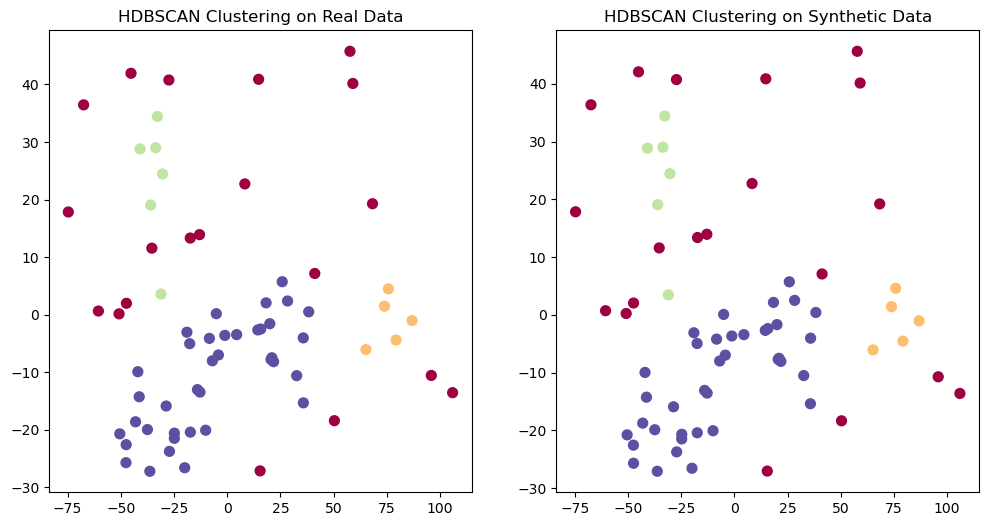

In [96]:
from hdbscan import HDBSCAN
def hdbscan_visualization():
    # Standaryzacja danych
    scaler = StandardScaler()
    real_scaled = scaler.fit_transform(real_data)
    synthetic_scaled = scaler.transform(synthetic_data)
    
    # PCA do 2 komponentów
    pca = PCA(n_components=2)
    real_pca = pca.fit_transform(real_scaled)
    synthetic_pca = pca.transform(synthetic_scaled)
    
    # HDBSCAN
    hdbscan = HDBSCAN()
    real_hdbscan = hdbscan.fit_predict(real_pca)
    synthetic_hdbscan = hdbscan.fit_predict(synthetic_pca)
    
    # Wizualizacja
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(real_pca[:, 0], real_pca[:, 1], c=real_hdbscan, cmap='Spectral', s=50)
    plt.title('HDBSCAN Clustering on Real Data')

    plt.subplot(1, 2, 2)
    plt.scatter(synthetic_pca[:, 0], synthetic_pca[:, 1], c=synthetic_hdbscan, cmap='Spectral', s=50)
    plt.title('HDBSCAN Clustering on Synthetic Data')
    plt.show()
    
hdbscan_visualization()

### Wykorzsyanie ICA

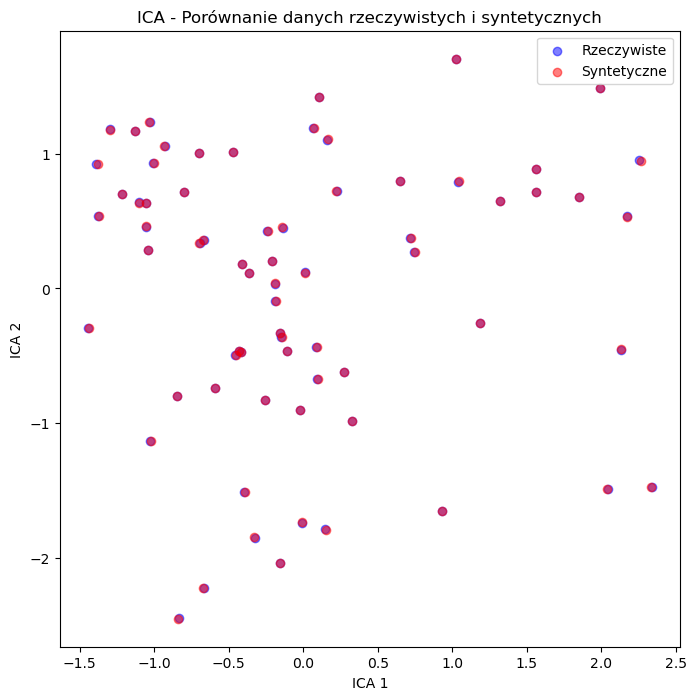

In [97]:
def ica_visualization():
    # Standaryzacja danych
    scaler = StandardScaler()
    real_scaled = scaler.fit_transform(real_data)
    synthetic_scaled = scaler.transform(synthetic_data)
    
    # ICA do 2 komponentów
    ica = FastICA(n_components=2)
    real_ica = ica.fit_transform(real_scaled)
    synthetic_ica = ica.transform(synthetic_scaled)
    
    # Wizualizacja
    plt.figure(figsize=(8, 8))
    plt.scatter(real_ica[:, 0], real_ica[:, 1], c='blue', alpha=0.5, label='Rzeczywiste')
    plt.scatter(synthetic_ica[:, 0], synthetic_ica[:, 1], c='red', alpha=0.5, label='Syntetyczne')
    plt.legend()
    plt.title('ICA - Porównanie danych rzeczywistych i syntetycznych')
    plt.xlabel('ICA 1')
    plt.ylabel('ICA 2')
    plt.show()

ica_visualization()

### Wykorzystanie MDS do wizualizacji różnorodności danych

d:\Apps\anaconda3\envs\poop\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
d:\Apps\anaconda3\envs\poop\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


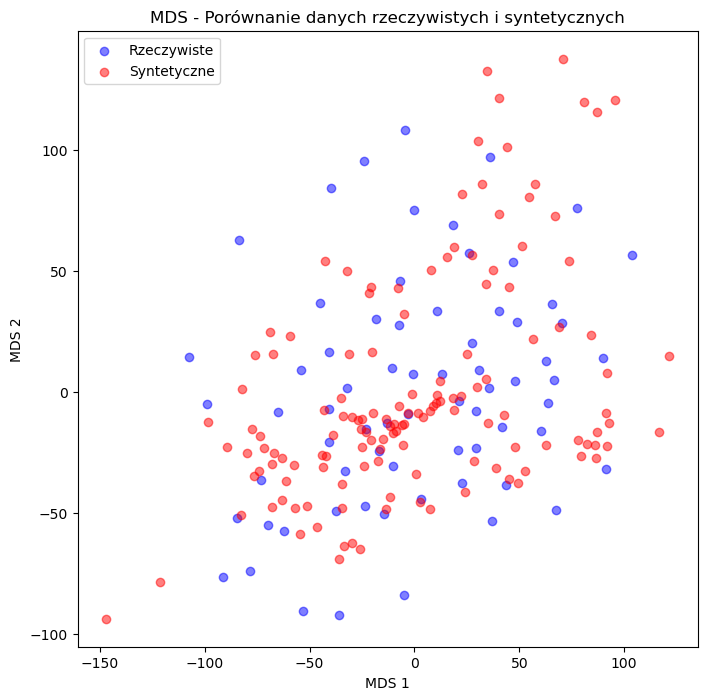

In [155]:
from sklearn.manifold import MDS
def mds_visualization():
    # Standaryzacja danych
    scaler = StandardScaler()
    real_scaled = scaler.fit_transform(real_data)
    synthetic_scaled = scaler.transform(synthetic_data)
    
    # MDS do 2 komponentów
    mds = MDS(n_components=2)
    real_mds = mds.fit_transform(real_scaled)
    synthetic_mds = mds.fit_transform(synthetic_scaled)
    
    # Wizualizacja
    plt.figure(figsize=(8, 8))
    plt.scatter(real_mds[:, 0], real_mds[:, 1], c='blue', alpha=0.5, label='Rzeczywiste')
    plt.scatter(synthetic_mds[:, 0], synthetic_mds[:, 1], c='red', alpha=0.5, label='Syntetyczne')
    plt.legend()
    plt.title('MDS - Porównanie danych rzeczywistych i syntetycznych')
    plt.xlabel('MDS 1')
    plt.ylabel('MDS 2')
    plt.show()

mds_visualization()

### wykorzystanie testu Mann-Whitneya

In [19]:
from scipy.stats import mannwhitneyu
import numpy as np

def mann_whitney_test(real_data, synthetic_data):
    p_values = []
    for column in real_data.columns:
        p_values.append(mannwhitneyu(real_data[column], synthetic_data[column])[1])
    return p_values

p_values = mann_whitney_test(real_data, synthetic_data)

# Implementacja korekty Benjamini-Hochberga
p_values_sorted = np.array(sorted(p_values))
m = len(p_values_sorted) # Liczba testów
q_values = np.empty(m)
prev_bh_value = 0

# Obliczanie skorygowanych wartości p (q-values)
for i, p in enumerate(p_values_sorted):
    bh_value = p * m / (i + 1)
    # Zapewnienie, że q-values są niemalejące
    bh_value = max(prev_bh_value, bh_value)
    q_values[i] = bh_value
    prev_bh_value = bh_value

# Porównywanie skorygowanych wartości p z poziomem istotności 0.05
significant_count = np.sum(q_values < 0.05)

print(f"Liczba istotnych kolumn po korekcie Benjamini-Hochberga: {significant_count} / {len(q_values)}")

Liczba istotnych kolumn po korekcie Benjamini-Hochberga: 1289
